In [1]:
import torch
import pytorch_lightning as pl
import yaml
import sys
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from glob import glob

In [2]:
sys.path.append("/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE")

In [14]:
from scripts.maploader.maploader import get_data_from_params, get_normalized_from_params
from scripts.utils.params import set_params
from scripts.diffusion.DDPM import linear_beta_schedule, Diffusion

In [5]:
base_dir = "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE"
params = set_params(base_dir,
        n_maps=1,
        order=8,
        transform_type="sigmoid",
        model="diffusion",
        conditioning="concat",
        norm_type="group",
        act_type="silu",
        block="biggan",
        mask=False,
        use_attn=False,
        scheduler="linear",
        target="HR", 
        batch_size=4)

In [6]:
lr, hr = get_data_from_params(params)
data_input, data_condition, transforms_lr, inverse_transform_lr, transforms_hr, inverse_transforms_hr, range_min_lr, range_max_lr, range_min_hr, range_max_hr = get_normalized_from_params(lr, hr, params)

LR data loaded from /gpfs02/work/akira.tokiwa/gpgpu/FastPM/healpix/nc128/.  Number of maps: 1
HR data loaded from /gpfs02/work/akira.tokiwa/gpgpu/FastPM/healpix/nc256/.  Number of maps: 1
data nside: 512, divided into 768 patches, each patch has 4096 pixels.
LR data normalized to [0.5,0.8507331013679504] by sigmoid transform.
HR data normalized to [0.5,0.9312711358070374] by sigmoid transform.


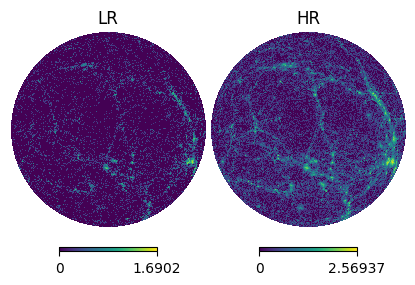

In [10]:
# data before normalization
plt.figure(figsize=(4, 4))
hp.orthview(np.hstack(lr[:, :, 0].detach().cpu().numpy()), half_sky=True, title="LR", sub=(1, 2, 1), nest=True)
hp.orthview(np.hstack(hr[:, :, 0].detach().cpu().numpy()), half_sky=True, title="HR", sub=(1, 2, 2), nest=True)
plt.show()

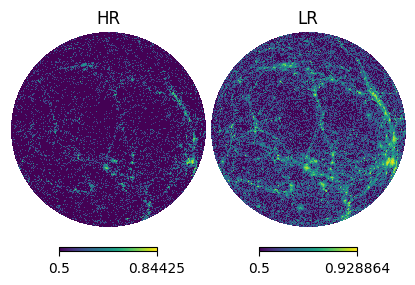

In [22]:
# data after normalization
plt.figure(figsize=(4, 4))
hp.orthview(np.hstack(data_condition[:, :, 0].detach().cpu().numpy()), half_sky=True, title="HR", sub=(1, 2, 1), nest=True)
hp.orthview(np.hstack(data_input[:, :, 0].detach().cpu().numpy()), half_sky=True, title="LR", sub=(1, 2, 2), nest=True)
plt.show()

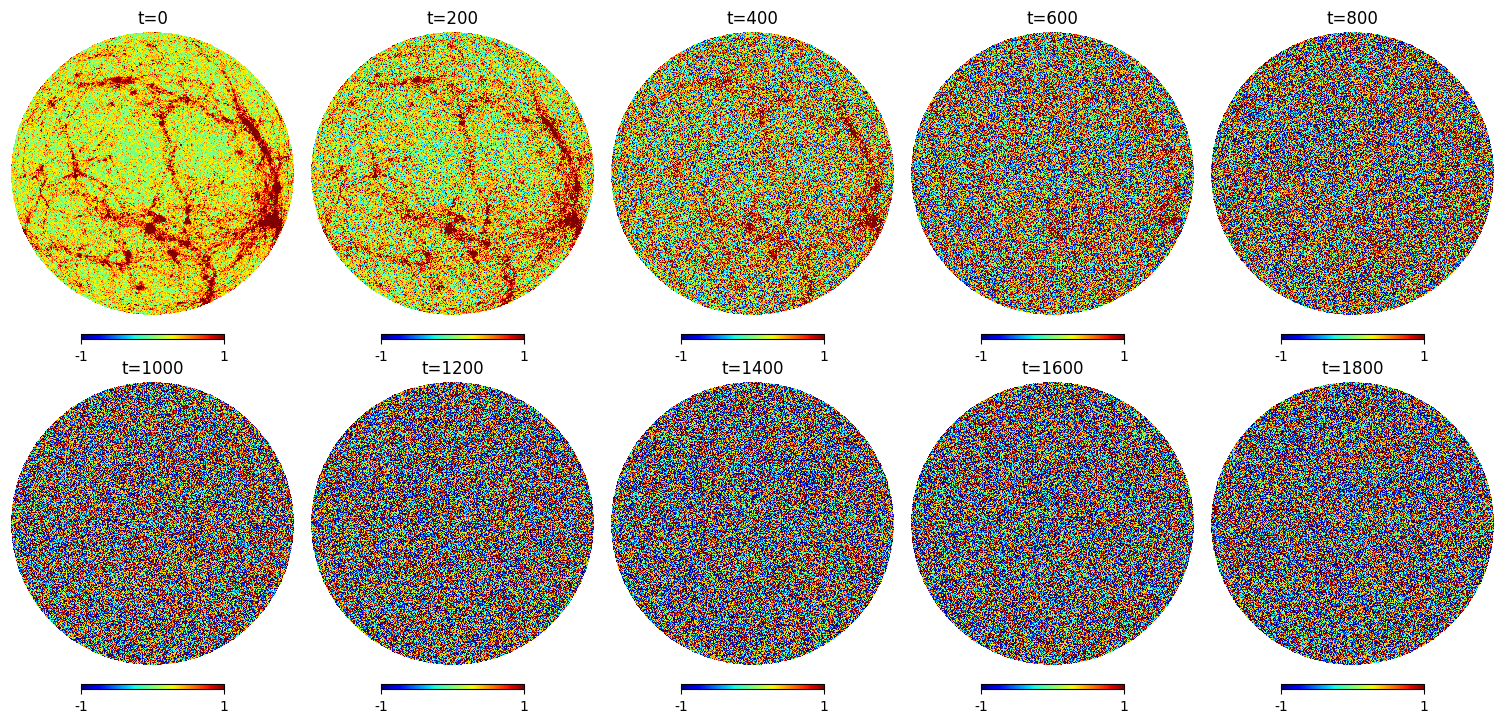

In [21]:
# diffused data
timesteps = int(params['diffusion']['timesteps'])
betas = linear_beta_schedule(timesteps=timesteps, beta_start=params['diffusion']['linear_beta_start'], beta_end=params['diffusion']['linear_beta_end'])
diffusion = Diffusion(betas)
sample_timesteps = [200*i for i in range(timesteps//200)]
tmp_hr = hr[:, :, 0]
fig = plt.figure(figsize=(15, 7))
for i, t in enumerate(sample_timesteps):
    time = torch.full((12*params["data"]["order"]**2,), t, dtype=torch.long)
    tmp_sample = diffusion.q_sample(tmp_hr, time)
    #print("mean {}, var {}".format(tmp_sample.mean(), tmp_sample.var()))
    hp.orthview(np.hstack(tmp_sample.detach().cpu().numpy()), fig=fig, nest=True, title=f"t={t}", sub=(2, 5, i+1), min=-1, max=1, cmap='jet', half_sky=True)